In [1]:
from fastai import *
from fastai.vision import *
import torchvision

In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)
!nvidia-smi -L

cuda
GPU 0: Tesla K80 (UUID: GPU-18ba588d-fe24-9f85-7ab3-2858d1e7ec82)


In [3]:
!pip install opendatasets --upgrade
import opendatasets as od
od.download('https://www.kaggle.com/puneet6060/intel-image-classification')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: karthikeyansundaram
Your Kaggle Key: ··········


100%|██████████| 346M/346M [00:02<00:00, 131MB/s]


In [4]:
BATCH_SIZE = 32
SIZE = 150

In [5]:
data = ImageDataBunch.from_folder('/content/intel-image-classification',
                                  train='seg_train',
                                  valid='seg_test',
                                  test='seg_pred',
                                  ds_tfms=get_transforms(
    do_flip=True, 
    max_rotate=9, 
    max_zoom=1.3,
    max_lighting=0.4,
    xtra_tfms=[
        jitter(magnitude=0.01, p=0.5),
        rgb_randomize(channel=0, thresh=0.9, p=0.1),
        rgb_randomize(channel=1, thresh=0.9, p=0.1),
        rgb_randomize(channel=2, thresh=0.9, p=0.1),
    ]
), size=SIZE, bs=BATCH_SIZE).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


In [6]:
data.label_list

LabelLists;

Train: LabelList (14034 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
buildings,buildings,buildings,buildings,buildings
Path: /content/intel-image-classification;

Valid: LabelList (3000 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
buildings,buildings,buildings,buildings,buildings
Path: /content/intel-image-classification;

Test: LabelList (7301 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: EmptyLabelList
,,,,
Path: /content/intel-image-classification

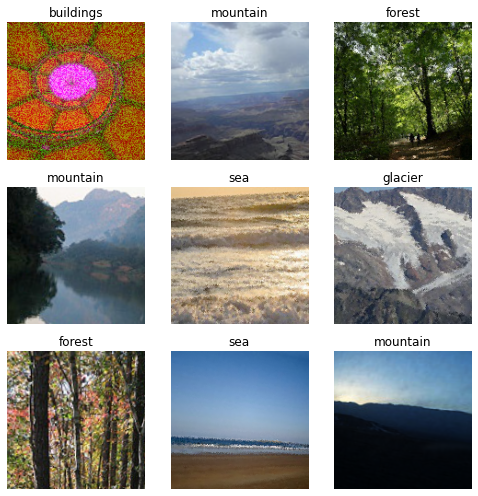

In [7]:
data.show_batch(rows=3, figsize=(7,7))

In [8]:
learn = cnn_learner(data, models.resnet50, pretrained=True, metrics=[error_rate, accuracy], model_dir="/content/model")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [9]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.705467,0.367384,0.123333,0.876667,02:23
1,0.505885,0.323837,0.112000,0.888000,02:18
2,0.432307,0.267013,0.092000,0.908000,02:18
3,0.384042,0.228398,0.085667,0.914333,02:18
4,0.357200,0.243247,0.091333,0.908667,02:18
5,0.325666,0.205991,0.075333,0.924667,02:18
6,0.265279,0.209585,0.079667,0.920333,02:18
7,0.268919,0.196910,0.076333,0.923667,02:18


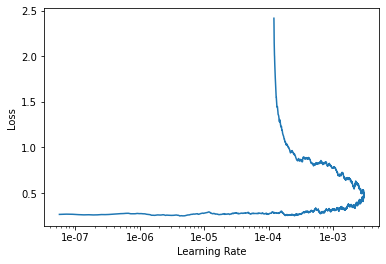

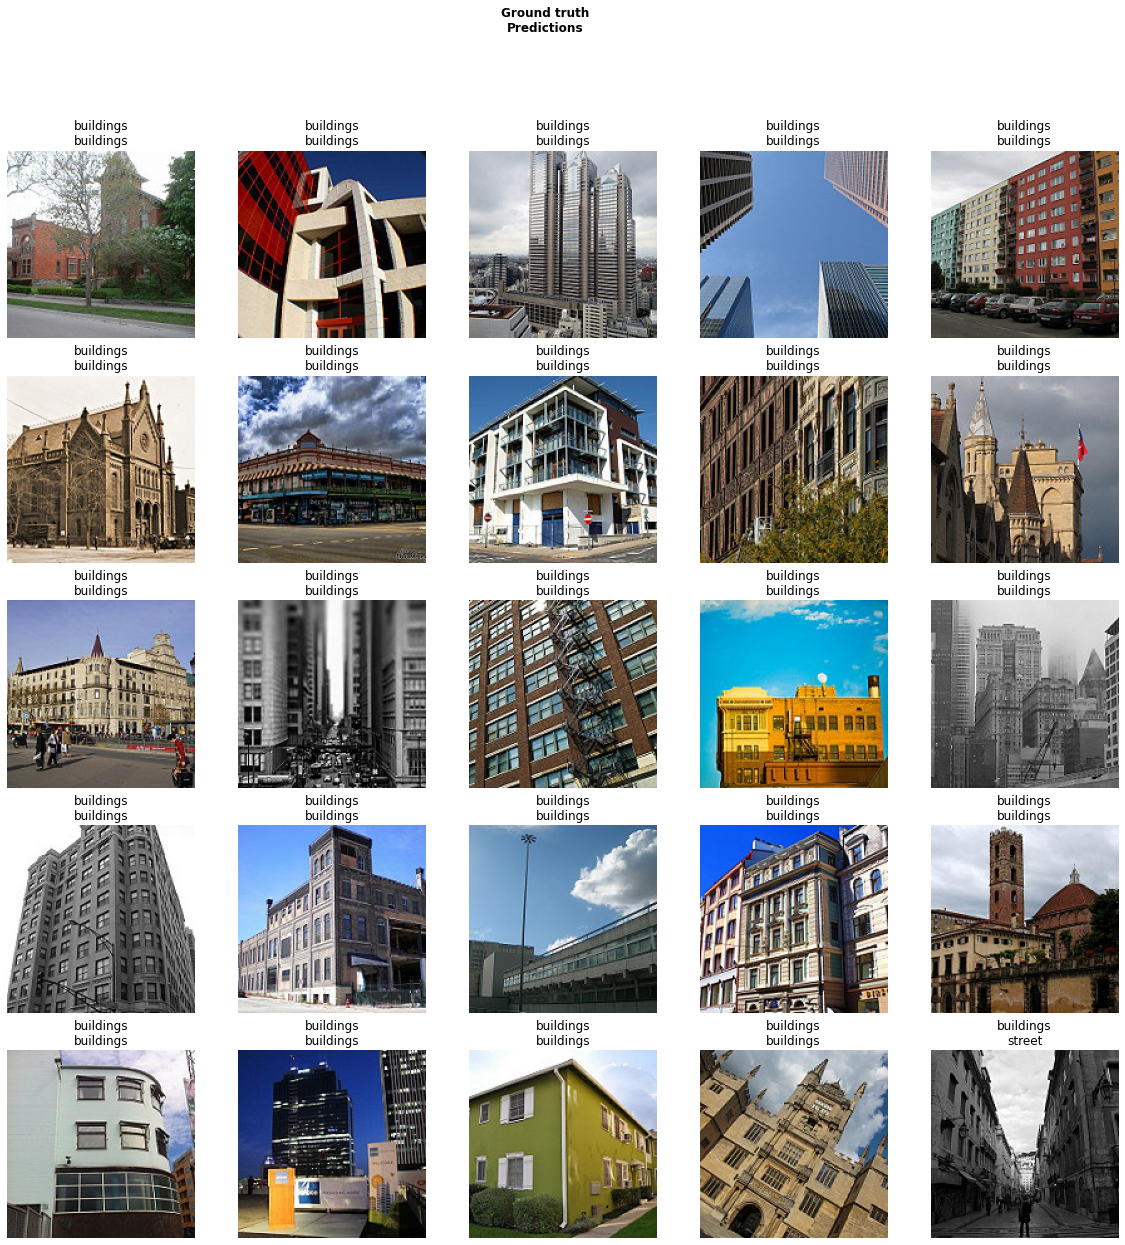

In [10]:
learn.recorder.plot()
learn.show_results(ds_type=DatasetType.Valid)

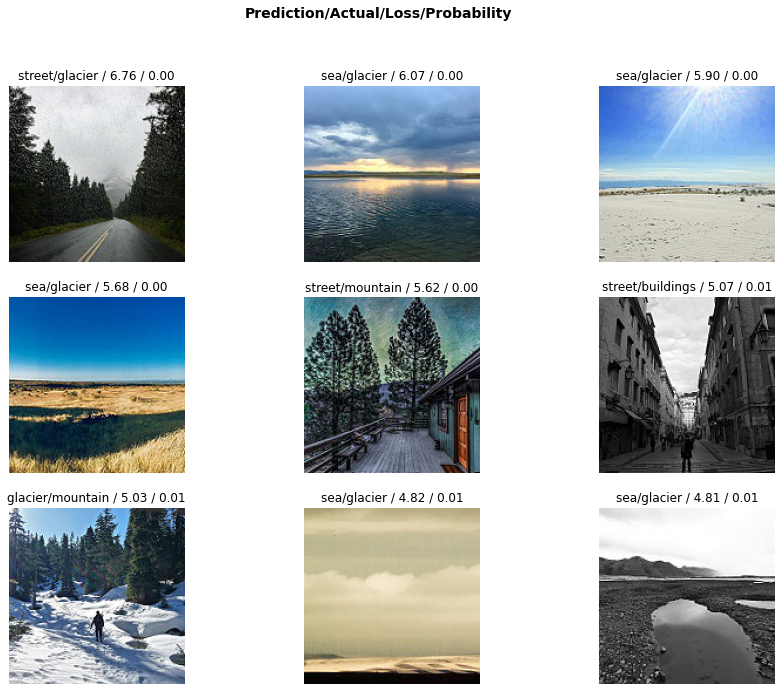

In [11]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_top_losses(9, figsize=(15,11))

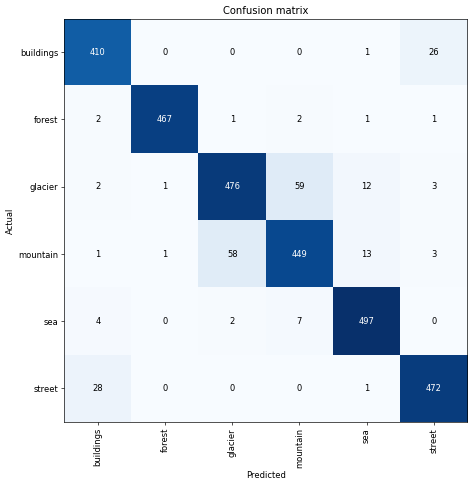

In [12]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [13]:
interp.most_confused(min_val=2)

[('glacier', 'mountain', 59),
 ('mountain', 'glacier', 58),
 ('street', 'buildings', 28),
 ('buildings', 'street', 26),
 ('mountain', 'sea', 13),
 ('glacier', 'sea', 12),
 ('sea', 'mountain', 7),
 ('sea', 'buildings', 4),
 ('glacier', 'street', 3),
 ('mountain', 'street', 3),
 ('forest', 'buildings', 2),
 ('forest', 'mountain', 2),
 ('glacier', 'buildings', 2),
 ('sea', 'glacier', 2)]

In [14]:
learn.save('save1-resnet50')

In [15]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


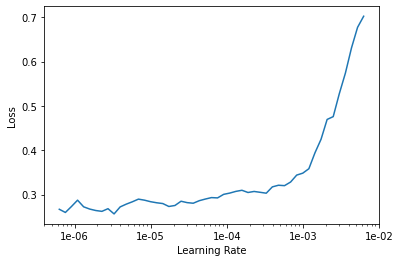

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.290799,0.193757,0.073667,0.926333,03:03
1,0.266397,0.188061,0.071000,0.929000,03:03
2,0.258975,0.184637,0.066333,0.933667,03:03
3,0.248885,0.180305,0.065667,0.934333,03:03
4,0.214140,0.179085,0.064333,0.935667,03:03
